# Predictive distribution for Bayesian Linear Regression

The predictive distribution takes the form
$$
    p(t | x, {\bf t}, \alpha, \beta) = \mathcal{N}\left(t \mid {\bf m}_N^T \phi({\bf x}), \frac{1}{\beta} + \phi({\bf x})^T{\bf S}_N\phi({\bf x})\right)
$$

We consider a Gaussian basis function of the form:
$$
    \phi_j(x) = \exp\left(-\frac{(x - \mu_j)^2}{2s^2}\right) 
$$

In [1]:
import numpy as np
import branca
import matplotlib.pyplot as plt

from numpy.linalg import inv

In [2]:
%config InlineBackend.figure_format = "retina"

Linear basis function of choice

In [3]:
def y(x): return np.sin(2 * np.pi * x)
x_true = np.linspace(0, 1, 100)
y_true = y(x_true)

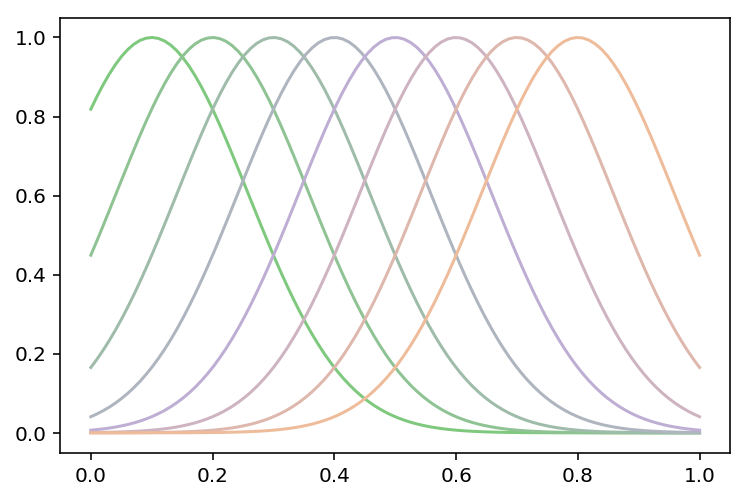

In [4]:
def gaussian_bf(x, mu, s): return np.exp(-(x - mu) ** 2 / s)

colors = branca.colormap.linear.Accent_03
s = 0.05
mu = np.arange(0.1, 0.9, 0.1)
for j, mu_j in enumerate(mu):
    plt.plot(x_true, gaussian_bf(x_true, mu_j, s), c=colors(j / len(mu)))

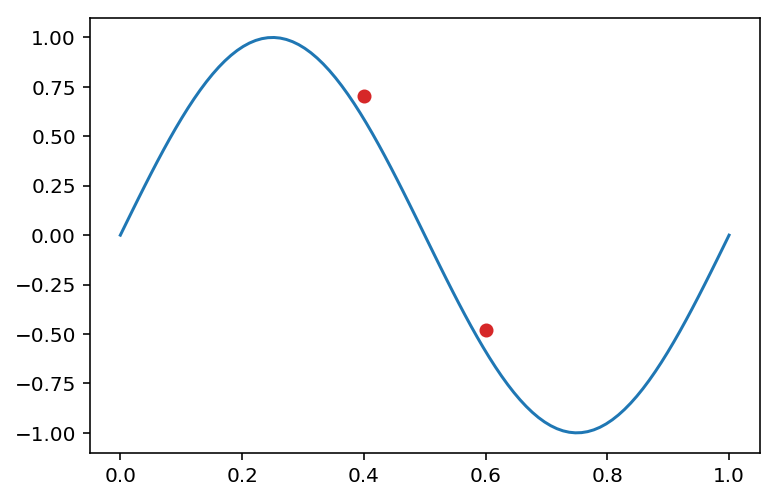

In [5]:
def sample_sinusoidal(S, beta, x_samp=None):
    x_samp = np.random.uniform(0, 1, S)  if x_samp is None else x_samp
    y_samp = y(x_samp) + np.random.randn(S) / beta
    return x_samp, y_samp

np.random.seed(314)
precision = 5
x_s1, y_s1 = sample_sinusoidal(1, precision)
x_s2, y_s2 = sample_sinusoidal(2, precision, x_samp=np.array([0.4, 0.6]))
x_s4, y_s4 = sample_sinusoidal(4, precision)
x_s25, y_s25 = sample_sinusoidal(30, precision)

plt.plot(x_true, y_true)
plt.scatter(x_s2, y_s2, c="tab:red")

In [6]:
def fill_basis(x, s, mu):
    Phi = np.column_stack((gaussian_bf(x, mu_j, s) for mu_j in mu))
    return Phi

In [7]:
def posterior_weights(alpha, s, beta, mus, x_train, y_train):
    Phi = fill_basis(x_train, s, mus)
    SN = inv(alpha + beta * Phi.T @ Phi)
    mN = beta * SN @ Phi.T @ y_train.reshape(-1, 1)
    return mN, SN

In [24]:
step = 0.1
s = 1
mu = np.arange(0, 1 + step, step)
alpha = 0.5
xtarget = x_s25
ytarget = y_s25
mN, SN = posterior_weights(alpha, s, precision, mu, xtarget,  ytarget)

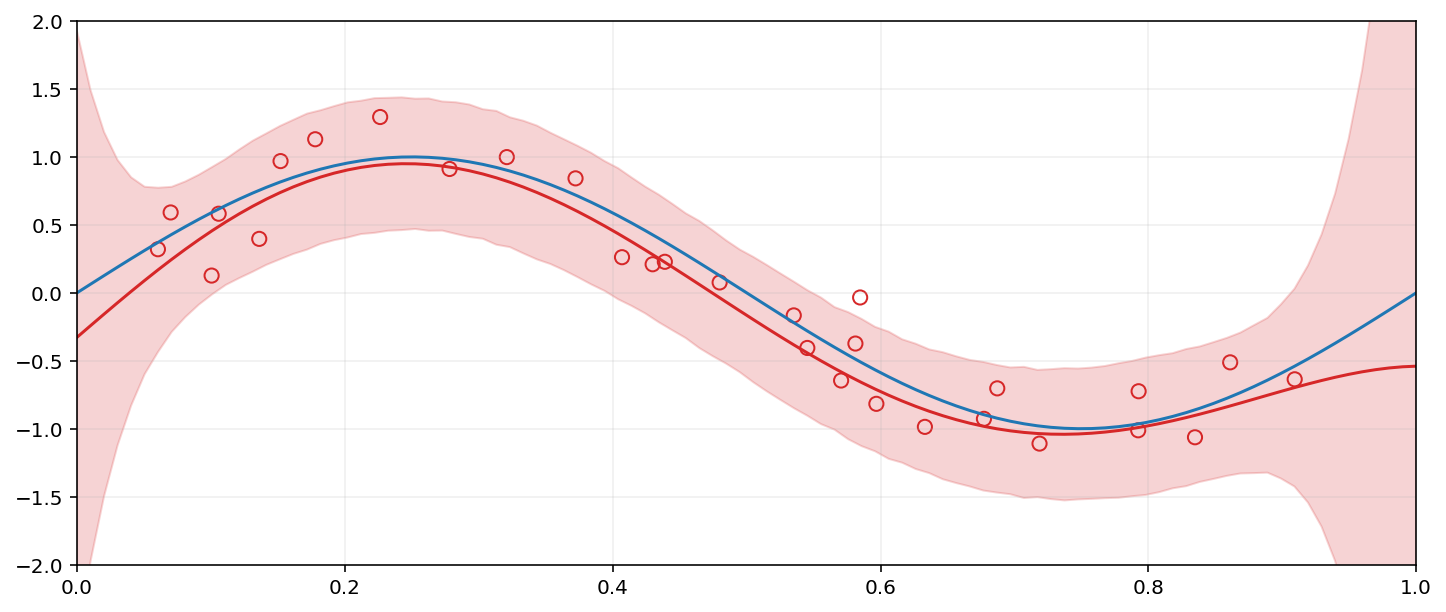

In [29]:
plt.figure(figsize=(12, 5))
mu_pred = mN.T @ fill_basis(x_true, s, mu).T
sigma_pred = 1 / precision + np.diag(fill_basis(x_true, s, mu) @ SN @ fill_basis(x_true, s, mu).T )

plt.plot(x_true, y_true)
plt.plot(x_true, mu_pred.T, c="tab:red")
plt.fill_between(x_true, np.ravel(mu_pred - 2 * sigma_pred),
                 np.ravel(mu_pred + 2 * sigma_pred),
                 color="tab:red", alpha=0.2)
plt.scatter(xtarget, ytarget, facecolors="none", edgecolors="tab:red", s=50)
plt.ylim(-2, 2); plt.xlim(0, 1)
plt.grid(alpha=0.2);